# Detect Adversarial Attacks Audio

## Checking Avilable GPU

In [19]:
!nvidia-smi

Thu Mar 16 12:27:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    42W / 350W |   4734MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [20]:
# pytorch libs
import torch
from torch import nn
import torchaudio

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks

from helper_functions import *

## device agnostic code

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Getting Dataset with pytorch

In [22]:
from torchvision import transforms

image_trasform = transforms.Compose(
    [
        # transforms.Grayscale(num_output_channels=1), # converting to 1 channel
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root="data/", download=True, train=True, transform=image_trasform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="data/", download=True, train=False, transform=image_trasform
)
train_dataset, test_dataset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [23]:
mod_train_data = torch.utils.data.Subset(train_dataset, range(0, len(train_dataset), 5))
mod_test_data = torch.utils.data.Subset(test_dataset, range(0, len(test_dataset), 2))
len(mod_train_data), len(mod_test_data)

(10000, 5000)

In [24]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=mod_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=mod_test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader


Numbers of Batches in Train Dataloader: 313
Numbers of Batches in Test Dataloader: 157


## Models Training

### set seeds function

In [25]:
### set seed function
def set_seed(seed: int = 42):
    """
    sets mannual seeds for both cpu and cuda
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


### making training, testing steps, train model functions

#### train step

In [26]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    attack = None,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      attack (torchattacks.Attack): Attack function (object) of your choice
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X, y) in dataloader:  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # Modifying the data
        data_c = attack(X, y) #purturbed data
        sample_idx = torch.randint(0, X.shape[0], (X.shape[0]//2,)).unique()
        # print(sample_idx)
        # print(y)
        y = torch.zeros(X.shape[0],dtype=torch.long).to(device)
        for i in sample_idx:
            X[i] = data_c[i]
            y[i] = 1
        # print(y)
        # Modifying the data End
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
        # print("Model parms diff:")
        # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
        # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
        train_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)


#### test step

In [27]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
    attack = None,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      attack (torchattacks.Attack): Attack function (object) of your choice
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # Modifying the data
        data_c = attack(X, y) #purturbed data
        sample_idx = torch.randint(0, X.shape[0], (X.shape[0]//2,)).unique()
        # print(sample_idx)
        # print(y)
        y = torch.zeros(X.shape[0],dtype=torch.long).to(device)
        for i in sample_idx:
            X[i] = data_c[i]
            y[i] = 1
        # print(y)
        # Modifying the data End
        
        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)

#### training function

In [28]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    attack = None,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      attack (torchattacks.Attack): Attack function (object) of your choice
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
            attack=attack,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
            attack=attack,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

    # 5. return result dict
    return result_dict


### train loop for model_resnet_dector normal training

In [37]:
from torchvision.models import resnet34, ResNet34_Weights
# Note that these weights may change across versions
# Best available weights (currently alias for IMAGENET1K_V2)
weights_resnet = ResNet34_Weights.DEFAULT
model_resnet_dector = resnet34(weights=weights_resnet).to(device)
auto_transforms_resnet = weights_resnet.transforms() # best available transforms
model_resnet_dector,auto_transforms_resnet

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [38]:
# freeze all the layers resnet
for param in model_resnet_dector.parameters():
    param.requires_grad = False
num_ftrs = model_resnet_dector.fc.in_features
model_resnet_dector.fc = nn.Linear(num_ftrs, 2)
model_resnet_dector.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
# logging model
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_resnet_34_15_epochs.pt"
# number of classes in dataset
# class_names = train_dataset.classes
# set_seed(seed=42)

# init. model
model_resnet_base = resnet34(weights=weights_resnet).to(device)
num_ftrs = model_resnet_base.fc.in_features
model_resnet_base.fc = nn.Linear(num_ftrs, 10).to(device)

model_resnet_base.load_state_dict(torch.load(NAME))
model_resnet_base.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
# init. epochs
NUM_EPOCHS = 5

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device=device)
optimizer = torch.optim.Adam(
    params=model_resnet_dector.parameters(), lr=0.001
)

# init. attack
attack = torchattacks.FGSM(model_resnet_base, eps=8/255)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer

start_time = timer()

# train model *uncomment to train the model*
model_resnet_results = train(
    model=model_resnet_dector,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    epochs=NUM_EPOCHS,
    attack=attack,
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5410 | train_acc: 0.7240 | test_loss: 0.5188 | test_acc: 0.7564
Epoch: 2 | train_loss: 0.4856 | train_acc: 0.7679 | test_loss: 0.5127 | test_acc: 0.7582
Epoch: 3 | train_loss: 0.4766 | train_acc: 0.7736 | test_loss: 0.4988 | test_acc: 0.7667
Epoch: 4 | train_loss: 0.4792 | train_acc: 0.7775 | test_loss: 0.4698 | test_acc: 0.7836
Epoch: 5 | train_loss: 0.4928 | train_acc: 0.7599 | test_loss: 0.4978 | test_acc: 0.7711
total training time: 75.495 sec.


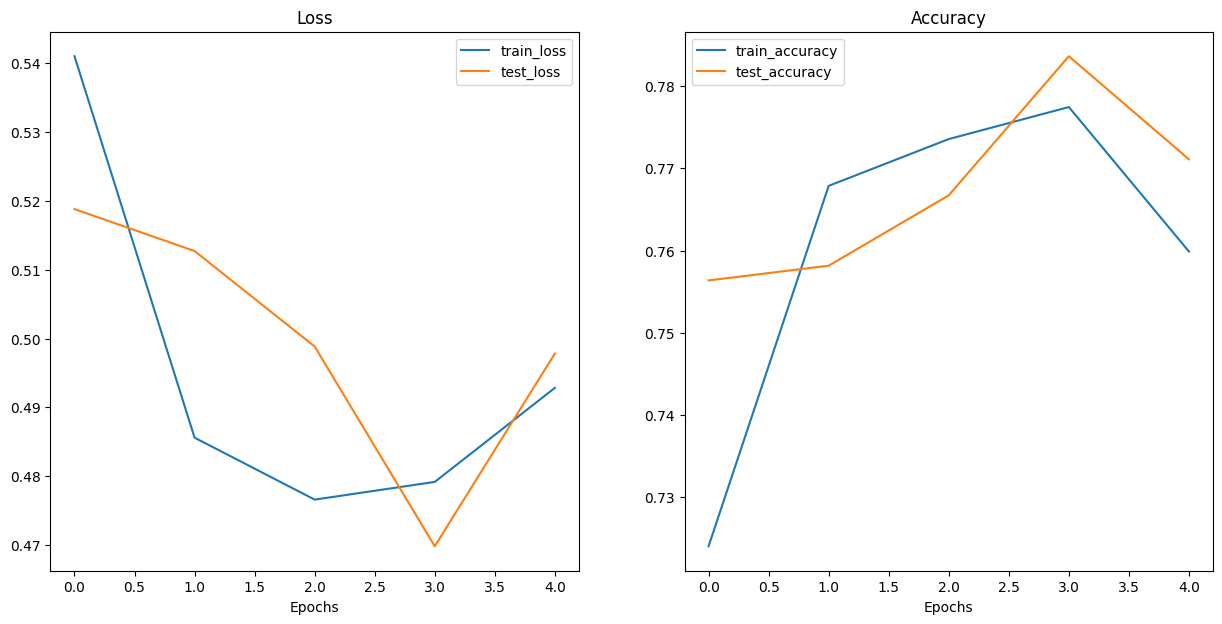

In [42]:
plot_loss_curves(model_resnet_results)

### Checking FGSM with difftrent epsilon

In [43]:
metric = Accuracy(task="multiclass", num_classes=2).to(device=device)
for epslion in torch.arange(0,1,0.0625):
    atk = torchattacks.FGSM(model_resnet_base, eps=epslion)
    acc = 0
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        data_c = attack(data, target) #purturbed data
        sample_idx = torch.randint(0, data.shape[0], (data.shape[0]//2,)).unique()
        # print(sample_idx)
        # print(y)
        target = torch.zeros(data.shape[0],dtype=torch.long).to(device)
        for i in sample_idx:
            data[i] = data_c[i]
            target[i] = 1
        output = model_resnet_dector(data)
        acc += metric(output, target).item()
    print(f'Purtubed Test accuracy: {acc / len(test_dataloader):.4f} with epsilion: {epslion}')

Purtubed Test accuracy: 0.7739 with epsilion: 0.0
Purtubed Test accuracy: 0.7751 with epsilion: 0.0625
Purtubed Test accuracy: 0.7705 with epsilion: 0.125
Purtubed Test accuracy: 0.7643 with epsilion: 0.1875
Purtubed Test accuracy: 0.7665 with epsilion: 0.25
Purtubed Test accuracy: 0.7759 with epsilion: 0.3125
Purtubed Test accuracy: 0.7691 with epsilion: 0.375
Purtubed Test accuracy: 0.7598 with epsilion: 0.4375
Purtubed Test accuracy: 0.7785 with epsilion: 0.5
Purtubed Test accuracy: 0.7657 with epsilion: 0.5625
Purtubed Test accuracy: 0.7665 with epsilion: 0.625
Purtubed Test accuracy: 0.7669 with epsilion: 0.6875
Purtubed Test accuracy: 0.7729 with epsilion: 0.75
Purtubed Test accuracy: 0.7757 with epsilion: 0.8125
Purtubed Test accuracy: 0.7701 with epsilion: 0.875
Purtubed Test accuracy: 0.7703 with epsilion: 0.9375


### Saving the trained model

#### saving

In [44]:
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_resnet_34_5_epochs_cfiar_10_detector.pt"
# saving model
try:
    torch.save(model_resnet_dector.state_dict(), NAME)
except:
    print("model not saved, check the path or saved models")

#### loading

In [45]:
# logging model
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_resnet_34_5_epochs_cfiar_10_detector.pt"
# # number of classes in dataset
# class_names = train_dataset.classes
# set_seed(seed=42)

# init. model
model_resnet_dector = resnet34(weights=weights_resnet).to(device)
model_resnet_dector.fc = nn.Linear(num_ftrs, 2).to(device)

model_resnet_dector.load_state_dict(torch.load(NAME))
model_resnet_dector.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### checking model after model

In [46]:
metric = Accuracy(task="multiclass", num_classes=2).to(device=device)
for epslion in torch.arange(0,1,0.0625):
    atk = torchattacks.FGSM(model_resnet_base, eps=epslion)
    acc = 0
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        data_c = attack(data, target) #purturbed data
        sample_idx = torch.randint(0, data.shape[0], (data.shape[0]//2,)).unique()
        # print(sample_idx)
        # print(y)
        target = torch.zeros(data.shape[0],dtype=torch.long).to(device)
        for i in sample_idx:
            data[i] = data_c[i]
            target[i] = 1
        output = model_resnet_dector(data)
        acc += metric(output, target).item()
    print(f'Purtubed Test accuracy: {acc / len(test_dataloader):.4f} with epsilion: {epslion}')

Purtubed Test accuracy: 0.7747 with epsilion: 0.0
Purtubed Test accuracy: 0.7697 with epsilion: 0.0625
Purtubed Test accuracy: 0.7731 with epsilion: 0.125
Purtubed Test accuracy: 0.7693 with epsilion: 0.1875
Purtubed Test accuracy: 0.7689 with epsilion: 0.25
Purtubed Test accuracy: 0.7793 with epsilion: 0.3125
Purtubed Test accuracy: 0.7703 with epsilion: 0.375
Purtubed Test accuracy: 0.7731 with epsilion: 0.4375
Purtubed Test accuracy: 0.7735 with epsilion: 0.5
Purtubed Test accuracy: 0.7588 with epsilion: 0.5625
Purtubed Test accuracy: 0.7753 with epsilion: 0.625
Purtubed Test accuracy: 0.7743 with epsilion: 0.6875
Purtubed Test accuracy: 0.7576 with epsilion: 0.75
Purtubed Test accuracy: 0.7709 with epsilion: 0.8125
Purtubed Test accuracy: 0.7617 with epsilion: 0.875
Purtubed Test accuracy: 0.7647 with epsilion: 0.9375


## 